<center> <h1> Beer Reviews </h1> </center>

The following jupyter notebook is an analysis of more 50,000 beers across the world and how users have reviewed them based on aroma, taste, appearance, palate, etc. We will first look at the different subtypes of ratings and how much correlation do they have to the overall rating and which are the strongest indicators of high rated beer. Secondly we will look at the relation between ABV(alcohol level by volume) and ratings. The notebook is split in three phases namely Data Cleaning, Exploratory Data Analysis and Modelling. 

#### 1. Data Preparation

All our data is placed in the database beer.db. With help sqlite3 we will extract only the data we require through SQL queries. The data we will use for our prediction will be average values for aroma, palate, appearance and so on for each beer.  

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
#Code for getting dataframes from various queries fired on the database
def query_result_df(q):
    conn = sqlite3.connect(r'C:\Users\phadk\Desktop\Work\projects\beer.db')
    con = conn.cursor()
    query = con.execute(q)
    cols = [column[0] for column in query.description]
    result_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return result_df

In [3]:
#getting a dataframe with all results from beer_master table 
data = query_result_df('''SELECT beer_beerid, beer_name, brewery_id, brewery_name, beer_style, beer_abv, ROUND(AVG(review_appearance),2) AS avg_review_appearance, 
ROUND(AVG(review_aroma),2) AS avg_review_aroma, ROUND(AVG(review_palate),2) AS avg_review_palate, 
ROUND(AVG(review_taste),2) AS avg_review_taste, ROUND(AVG(review_overall),2) AS avg_review_overall 
FROM beer_reviews 
GROUP BY beer_beerid''')

In [4]:
data.head()

,beer_beerid,beer_name,brewery_id,brewery_name,beer_style,beer_abv,avg_review_appearance,avg_review_aroma,avg_review_palate,avg_review_taste,avg_review_overall
0,3,Cactus Queen IPA,2,Yellow Rose Brewing Company,American IPA,NaN,3.83,4.00,4.17,4.17,4.17
1,4,Wildcatter's Crude Stout,2,Yellow Rose Brewing Company,American Stout,NaN,3.95,3.80,3.70,3.45,3.70
2,5,Amber,3,Abita Brewing Co.,Vienna Lager,4.5,3.49,3.21,3.32,3.34,3.55
3,6,Turbodog,3,Abita Brewing Co.,English Brown Ale,5.6,3.84,3.52,3.51,3.65,3.71
4,7,Purple Haze,3,Abita Brewing Co.,Fruit / Vegetable Beer,4.2,3.25,3.18,3.11,3.10,3.27


#### 1. Data Cleaning

In [5]:
data.describe()

,beer_beerid,brewery_id,beer_abv,avg_review_appearance,avg_review_aroma,avg_review_palate,avg_review_taste,avg_review_overall
count,66055.000000,66055.000000,49012.000000,66055.000000,66055.000000,66055.000000,66055.000000,66055.000000
mean,39718.135084,6855.265294,6.271890,3.686760,3.553423,3.575470,3.600068,3.656606
std,22416.177772,7482.954279,2.050938,0.507154,0.588795,0.579625,0.629013,0.621716
min,3.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,20503.500000,879.000000,5.000000,3.500000,3.250000,3.250000,3.310000,3.420000
50%,40506.000000,3073.000000,5.700000,3.750000,3.580000,3.670000,3.690000,3.750000
75%,59206.500000,11814.000000,7.200000,4.000000,4.000000,4.000000,4.000000,4.000000
max,77317.000000,28003.000000,57.700000,5.000000,5.000000,5.000000,5.000000,5.000000


Here We see that reviews are given between a value of 1 to 5. The value of beer ABV(Alcohol By Volume) level is continuous value upto 57.7.

In [6]:
data.isna().sum()

beer_beerid                  0
beer_name                    0
brewery_id                   0
brewery_name                11
beer_style                   0
beer_abv                 17043
avg_review_appearance        0
avg_review_aroma             0
avg_review_palate            0
avg_review_taste             0
avg_review_overall           0
dtype: int64

We see that beer_abv column has 17043 missing values. Here we can use a few strategies to fill out these values. We can analyze if certain beer styles in our dataset have a particular abv range and then fill the abv values as per our analysis.  

In [7]:
#query to get average abv values from the style of a certain beer
data_abv = query_result_df('''SELECT beer_style,min(beer_abv)+ max(beer_abv)/2 AS avg_abv 
FROM (SELECT beer_beerid, beer_name, brewery_id, brewery_name, beer_style, beer_abv, ROUND(AVG(review_appearance),2) AS avg_review_appearance, 
ROUND(AVG(review_aroma),2) AS avg_review_aroma, ROUND(AVG(review_palate),2) AS avg_review_palate, 
ROUND(AVG(review_taste),2) AS avg_review_taste, ROUND(AVG(review_overall),2) AS avg_review_overall 
FROM beer_reviews 
GROUP BY beer_beerid)
GROUP BY beer_style''')

data = data.merge(data_abv,how="left",on='beer_style')
data['beer_abv'] = data['beer_abv'].fillna(value=data['avg_abv'])

data.drop(['avg_abv'], axis=1, inplace=True)

#### 2. Exploratory Data Analysis

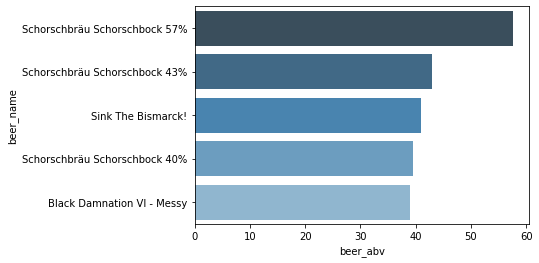

In [8]:
viz_abv = data.sort_values('beer_abv').tail(5)
sns.barplot(x="beer_abv",y="beer_name",  
            palette="Blues_d", 
            order=viz_abv.sort_values('beer_abv',ascending=False).beer_name,
            label = "Beers with Highest ABV",
            data=viz_abv)

In [9]:
viz_abv = data.sort_values('avg_review_taste').tail(10)
viz_abv[['beer_name','brewery_name','beer_style','beer_abv']]

,beer_name,brewery_name,beer_style,beer_abv
53491,Biere Blonde,Ninkasi Fabriques,American Blonde Ale,4.5
48640,Diamond Knot IPA (Dry Hopped With Simcoe),Diamond Knot Brewery,American IPA,6.0
53499,Chocolate Orange Delight,Downton Brewery Company,Milk / Sweet Stout,5.8
6553,Christmas Stark Lager,Red Oak Brewery,Märzen / Oktoberfest,5.7
33583,Caves Right Pilsner,Ram Restaurant & Brewery,Czech Pilsener,4.8
28745,Wiltse's Blue Ox Stout,Wiltse's Brew Pub and Family Restaurant,American Stout,8.5
50829,Addlepated Ale,Titletown Brewing Company,American Amber / Red Ale,6.5
39265,Tcheca,Micro Cervejaria Bamberg,Czech Pilsener,5.4
28708,Telewhacker,The Livery,American Brown Ale,6.5
62125,Cape May Wheat,Cape May Brewing Company,American Pale Wheat Ale,7.4


In [10]:
viz_abv = data.sort_values('avg_review_overall').tail(10)
viz_abv[['beer_name','brewery_name','beer_style','beer_abv']]

,beer_name,brewery_name,beer_style,beer_abv
30456,John's Mild Bitter,Phantom Canyon Brewing Company,English Dark Mild Ale,5.25
53166,La Libertine,Brasserie Des Vignes,Belgian Pale Ale,5.00
58214,Mango Double Simcoe,Weyerbacher Brewing Co.,American Double / Imperial IPA,9.00
19836,Weizenbock,Silver Peak Restaurant & Brewery,Weizenbock,6.50
53141,Barley O'Gnarly,Mick Duff's Brewing Company,American Barleywine,9.60
19795,Moon Beam Blue,Astoria Brewing Company / Wet Dog Cafe,Fruit / Vegetable Beer,4.20
5089,J.J.'s Hefeweizen,J.J. Bitting Brewing Company,Hefeweizen,4.80
19710,Blackberry Ale,John Harvard's Brewery & Ale House,Fruit / Vegetable Beer,9.90
19890,La Sambresse Blonde,Brasserie Brootcoorens,Belgian Strong Pale Ale,8.00
14121,White Lion,Red Lion Ales,American Blonde Ale,4.30


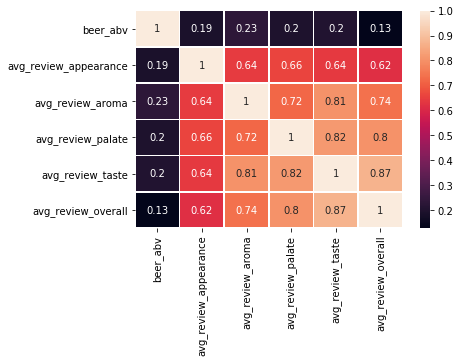

In [11]:
data_quant = data[['beer_abv','avg_review_appearance','avg_review_aroma',
                   'avg_review_palate','avg_review_taste', 'avg_review_overall']]
corr = data_quant.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidth=0.5)

Here we see that taste, palate and aroma are most closely related to high overall ratings. Next we will look at how these three factors on a regression line.

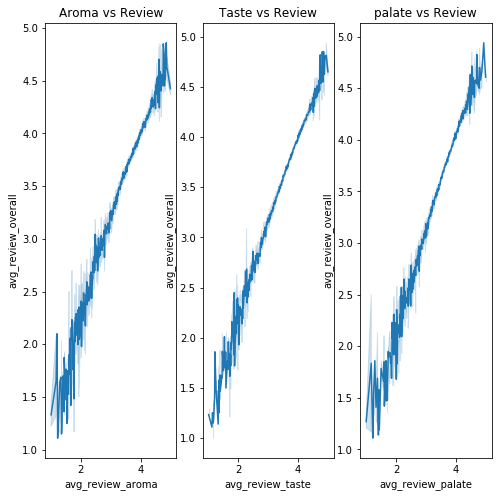

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(8,8))
sns.lineplot(x='avg_review_aroma',y='avg_review_overall', data=data, ax = ax1).set_title('Aroma vs Review');
sns.lineplot(x='avg_review_taste',y='avg_review_overall', data=data, ax = ax2).set_title('Taste vs Review');
sns.lineplot(x='avg_review_palate',y='avg_review_overall', data=data, ax = ax3).set_title('palate vs Review');
plt.show()


We see that aroma, taste and palate are good indicator to a highly rated beer. So these can be used in our Regression models.

#### 3. Regression

To predict the overall beer quality we will look at how consumers rated aroma, palate and taste. We will use Multiple Linear Regression to build our model.

In [28]:
X = data[['avg_review_aroma','avg_review_palate','avg_review_taste']]
Y = data[['avg_review_overall']]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=42)

In [30]:
#Define the Model
model = linear_model.LinearRegression(normalize = True)
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [31]:
#predicting on test data
pred = model.predict(x_test)

In [24]:
# prediction with sklearn
aroma = 4.4
palate = 3.9
taste = 4.2
print ('Predicted Overall Beer Quality: \n', model.predict([[aroma,palate,taste]]))

Predicted Overall Beer Quality: 
 [[4.16391755]]


In [39]:
rmse = np.sqrt(mean_squared_error(y_test,pred))
print('RMSE: {}'.format(rmse))

r2 = r2_score(y_test,pred)
print('R-Sqruared: {}'.format(r2))

RMSE: 0.28316395826220864
R-Sqruared: 0.797139119212154


#### 4. Conclusion

From our regression model we got great results for predicting our beer quality with factors like aroma, palate and taste. Our Root squared Mean Error was 0.28 and r-Squared value was 0.79. These metric show us that our model is highly accurate for prediction. 

In conclusion if your beer smells good, has a great taste and gives the consumer a good mouth feel then your beer will be quite popular. 